# Load

In [17]:
# --- Cell 1: Import & Load Images ---
import cv2, numpy as np, matplotlib.pyplot as plt, os

# Đọc ảnh cho từng phần
img_input  = cv2.imread('input/teddy-frame10.png', cv2.IMREAD_GRAYSCALE)
img_left   = cv2.imread('input/left.jpg',  cv2.IMREAD_GRAYSCALE)
img_right  = cv2.imread('input/right.jpg', cv2.IMREAD_GRAYSCALE)
imgs_pano  = [cv2.imread(f'input/redcanyon-00{i}.JPG') for i in range(42,46) if os.path.exists(f'input/redcanyon-00{i}.JPG')]

# Kiểm tra
print("Loaded:",
      f"\n  input:  {img_input is not None}",
      f"\n  stereo:    {img_left is not None and img_right is not None}",
      f"\n  pano imgs: {len(imgs_pano)}")


Loaded: 
  input:  True 
  stereo:    True 
  pano imgs: 4


# A

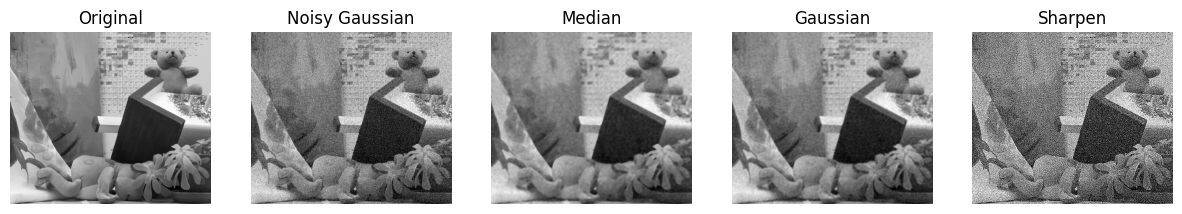


--- Noise: Gaussian ---
Mean             PSNR=27.21  GradSim=0.398
Gaussian         PSNR=28.71  GradSim=0.636
Median           PSNR=27.75  GradSim=0.567
LaplacianSharpen PSNR=11.32  GradSim=-9.123


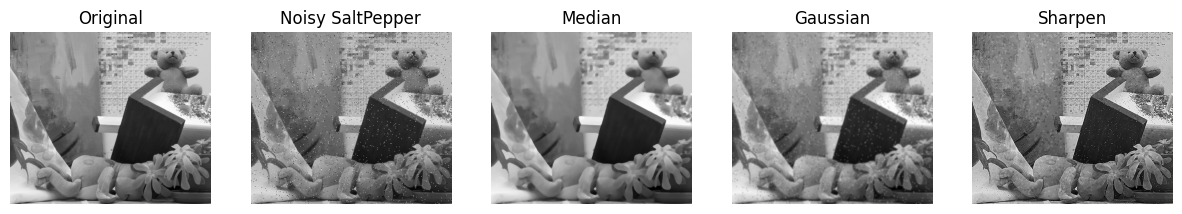


--- Noise: SaltPepper ---
Mean             PSNR=27.14  GradSim=0.386
Gaussian         PSNR=28.67  GradSim=0.621
Median           PSNR=29.65  GradSim=0.708
LaplacianSharpen PSNR=17.80  GradSim=-0.998


In [18]:
def imshow_grid_A(imgs, titles=None, cmap='gray', figsize=(12,4)):
    plt.figure(figsize=figsize)
    for i, im in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        plt.imshow(im, cmap=cmap)
        if titles: plt.title(titles[i])
        plt.axis('off')
    plt.show()

def PSNR_A(a, b):
    mse = np.mean((a.astype(np.float32) - b.astype(np.float32))**2)
    if mse == 0: return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def grad_sim_A(a, b):
    gx_a = cv2.Sobel(a, cv2.CV_32F, 1, 0, 3)
    gy_a = cv2.Sobel(a, cv2.CV_32F, 0, 1, 3)
    gx_b = cv2.Sobel(b, cv2.CV_32F, 1, 0, 3)
    gy_b = cv2.Sobel(b, cv2.CV_32F, 0, 1, 3)
    ga, gb = np.sqrt(gx_a**2+gy_a**2), np.sqrt(gx_b**2+gy_b**2)
    mse = np.mean((ga-gb)**2)
    return 1 - mse/(np.var(ga)+1e-8)

def partA_image_filtering(img_gray):
    base = img_gray
    # Noise
    gauss = np.clip(base + np.random.normal(0,20,base.shape),0,255).astype(np.uint8)
    sp = base.copy(); rnd = np.random.rand(*base.shape)
    sp[rnd<0.01]=0; sp[rnd>0.99]=255
    noises = {'Gaussian': gauss, 'SaltPepper': sp}
    results = {}

    for nname, noisy in noises.items():
        mean_ = cv2.blur(noisy,(5,5))
        gauss_ = cv2.GaussianBlur(noisy,(5,5),0)
        median_ = cv2.medianBlur(noisy,5)
        lap = cv2.Laplacian(noisy,cv2.CV_32F); sharp = np.clip(noisy - 0.7*lap,0,255).astype(np.uint8)
        filters = {'Mean':mean_,'Gaussian':gauss_,'Median':median_,'LaplacianSharpen':sharp}
        table = {k:(PSNR_A(base,v),grad_sim_A(base,v)) for k,v in filters.items()}
        results[nname]={'noisy':noisy,'filters':filters,'metrics':table}

        imshow_grid_A([base,noisy,median_,gauss_,sharp],
                      ['Original',f'Noisy {nname}','Median','Gaussian','Sharpen'],figsize=(15,4))
        print(f"\n--- Noise: {nname} ---")
        for k,(p,s) in table.items():
            print(f"{k:16s} PSNR={p:.2f}  GradSim={s:.3f}")

    return results

resA = partA_image_filtering(img_input)

# B

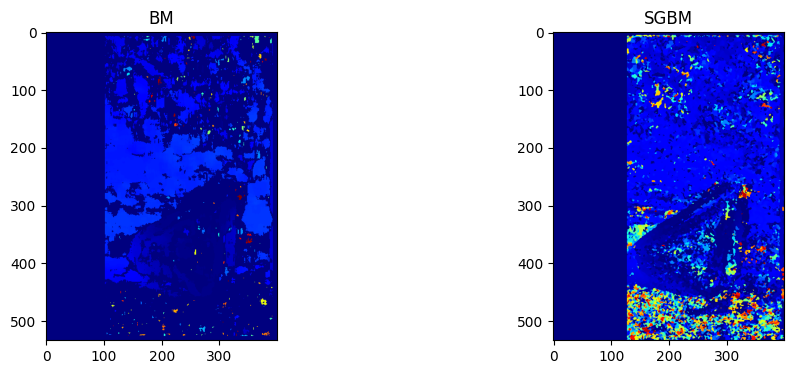

Saved output/pointcloudB.ply


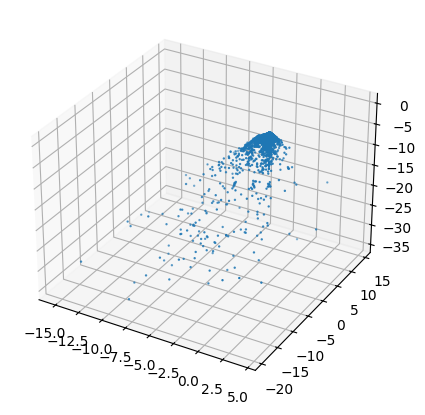

Inliers: 186 / 200
Block matching: Find the minimum horizontal shift cost within the window, SGBM uses global optimization for smoother results.


In [21]:
# --- Part B: 3D Reconstruction (fixed grayscale support) ---
def disparity_B(imgL, imgR, method='BM', numDisp=128, block=15):
    L = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY) if imgL.ndim == 3 else imgL
    R = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY) if imgR.ndim == 3 else imgR
    if method == 'BM':
        s = cv2.StereoBM_create(numDisp, block)
        d = s.compute(L, R).astype(np.float32) / 16
    else:
        s = cv2.StereoSGBM_create(numDisparities=numDisp, blockSize=block)
        d = s.compute(L, R).astype(np.float32) / 16
    return d

def pointcloud_B(disp, imgL, f=0.9, baseline=0.06):
    h, w = disp.shape
    Q = np.array([[1, 0, 0, -w / 2],
                  [0, 1, 0, -h / 2],
                  [0, 0, 0, f * w],
                  [0, 0, -1 / baseline, 0]], np.float32)
    pts = cv2.reprojectImageTo3D(disp, Q)
    mask = disp > disp.min() + 1
    if imgL.ndim == 2:
        colors = cv2.cvtColor(imgL, cv2.COLOR_GRAY2BGR)[mask]
    else:
        colors = imgL[mask]
    return pts[mask], colors

def save_ply_B(path, verts, colors):
    with open(path, 'w') as f:
        f.write('ply\nformat ascii 1.0\n')
        f.write(f'element vertex {len(verts)}\n')
        f.write('property float x\nproperty float y\nproperty float z\n')
        f.write('property uchar red\nproperty uchar green\nproperty uchar blue\nend_header\n')
        for v, c in zip(verts, colors):
            f.write(f"{v[0]} {v[1]} {v[2]} {int(c[0])} {int(c[1])} {int(c[2])}\n")
    print('Saved', path)

def partB_3D(imgL, imgR):
    d_bm = disparity_B(imgL, imgR, 'BM', 96, 15)
    d_sgbm = disparity_B(imgL, imgR, 'SGBM', 128, 5)
    plt.figure(figsize=(12, 4))
    plt.subplot(121); plt.imshow(d_bm, cmap='jet'); plt.title('BM')
    plt.subplot(122); plt.imshow(d_sgbm, cmap='jet'); plt.title('SGBM')
    plt.show()

    verts, cols = pointcloud_B(d_sgbm, imgL)
    save_ply_B('output/pointcloudB.ply', verts, cols)

    subs = verts[::max(1, len(verts) // 4000)]
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(subs[:, 0], subs[:, 1], subs[:, 2], s=0.5)
    plt.show()

    det = cv2.ORB_create(2000)
    kp1, des1 = det.detectAndCompute(imgL, None)
    kp2, des2 = det.detectAndCompute(imgR, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    m = sorted(bf.match(des1, des2), key=lambda x: x.distance)[:200]
    pts1 = np.float32([kp1[x.queryIdx].pt for x in m])
    pts2 = np.float32([kp2[x.trainIdx].pt for x in m])
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
    print("Inliers:", int(mask.sum()), "/", len(m))
    print("Block matching: Find the minimum horizontal shift cost within the window, SGBM uses global optimization for smoother results.")

resB = partB_3D(img_left, img_right)


# C

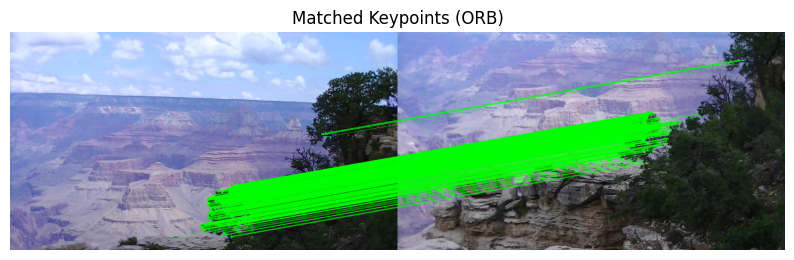

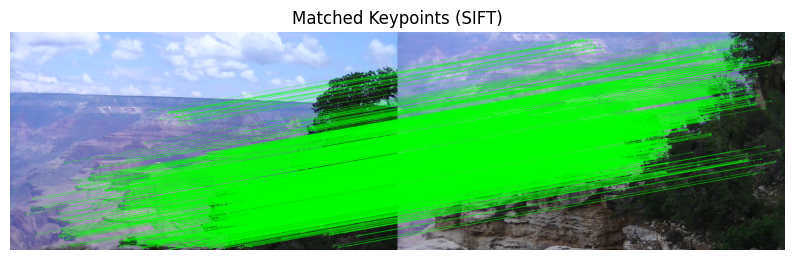

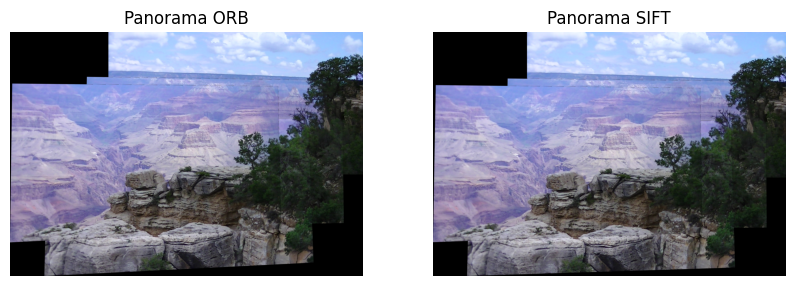

In [20]:
def match_and_homography(img1, img2, detector='ORB'):
    if detector == 'SIFT':
        det = cv2.SIFT_create()
        norm = cv2.NORM_L2
    else:
        det = cv2.ORB_create(2000)
        norm = cv2.NORM_HAMMING

    # Detect keypoints and descriptors
    kp1, des1 = det.detectAndCompute(img1, None)
    kp2, des2 = det.detectAndCompute(img2, None)

    # Match features
    matcher = cv2.BFMatcher(norm)
    matches = matcher.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    if len(good) < 4:
        return None, None, [], kp1, kp2

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Homography with RANSAC
    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    return H, mask, good, kp1, kp2

def stitch_images(imgs, detector='ORB'):
    pano = imgs[0]
    for i in range(1, len(imgs)):
        img_next = imgs[i]
        H, mask, good, kp1, kp2 = match_and_homography(pano, img_next, detector)
        if H is None:
            print(f"Skipping image {i}: insufficient matches")
            continue

        # --- Visualization: matched keypoints ---
        if i == 1:  # visualize only once
            matched_vis = draw_matches(pano, img_next, kp1, kp2, good, mask)
            plt.figure(figsize=(10,5))
            plt.imshow(cv2.cvtColor(matched_vis, cv2.COLOR_BGR2RGB))
            plt.title(f"Matched Keypoints ({detector})")
            plt.axis('off')
            plt.show()

        # Compute canvas size
        h1, w1 = pano.shape[:2]
        h2, w2 = img_next.shape[:2]
        corners_next = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
        warped_corners = cv2.perspectiveTransform(corners_next, H)
        corners = np.concatenate((np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2),
                                 warped_corners), axis=0)

        [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
        [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)
        trans = [-xmin, -ymin]

        H_translate = np.array([[1, 0, trans[0]], [0, 1, trans[1]], [0, 0, 1]])
        result = cv2.warpPerspective(img_next, H_translate @ H, (xmax - xmin, ymax - ymin))

        # Simple blending
        mask = (result[trans[1]:h1 + trans[1], trans[0]:w1 + trans[0]] == 0)
        result[trans[1]:h1 + trans[1], trans[0]:w1 + trans[0]][mask] = pano[mask]



        pano = result

    return pano


def draw_matches(img1, img2, kp1, kp2, matches, mask):
    draw_params = dict(matchColor=(0,255,0), singlePointColor=None, matchesMask=mask.ravel().tolist(), flags=2)
    return cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)

# ==== Example ====
if len(imgs_pano) < 4:
    print("Need at least 4 images.")
else:
    pano_orb = stitch_images(imgs_pano, 'ORB')
    pano_sift = stitch_images(imgs_pano, 'SIFT')

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(pano_orb, cv2.COLOR_BGR2RGB))
    plt.title('Panorama ORB'); plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(pano_sift, cv2.COLOR_BGR2RGB))
    plt.title('Panorama SIFT'); plt.axis('off')
    plt.show()

